# Checking sentiment of my product

<b>Name:</b> Pyae Sone Kyaw <b>Student Id:</b> st123225 <b>Course:</b> Natural Language Understanding <b>Assignment_5 : checking sentiment of my product</b> 

## Dataset

'Standard Sentiment Treebank' dataset was used for training a model for sentiment analysis. It was loaded through torchtext package. After dataset has a label of 0 and 1 corresponding to 'negative' and 'positive' respectively.

In [18]:
import torch, torchdata, torchtext
from torch import nn

import time

#1. puffer - it's outdated....
#2. spend some money - 300 baht get collab pro

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#reproducibility 
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [19]:
torch.__version__

'1.13.1+cpu'

In [20]:
torchtext.__version__

'0.14.1'

In [21]:
torchdata.__version__

'0.5.1'

In [22]:
#torch.cuda.get_device_name(0)

# 1) Load Dataset

In [23]:
from torchtext.datasets import SST2

train = SST2(split='train')
test = SST2(split='dev')

In [24]:
train

ShardingFilterIterDataPipe

# 2) EDA - exploratory data analysis

In [25]:
next(iter(train))

('hide new secretions from the parental units', 0)

In [26]:
list(iter(train))[100]

('in memory', 1)

In [27]:
set([y for x, y in list(iter(train))])

{0, 1}

In [28]:
train_size = len(list(iter(train)))
train_size

67349

In [29]:
train

ShardingFilterIterDataPipe

In [30]:
train, val = train.random_split(total_length=train_size, 
                                            weights = {"train": 0.99, 
                                                       "val": 0.01},
                                            seed = SEED)

In [31]:
train_size = len(list(iter(train)))
val_size   = len(list(iter(val)))
test_size  = len(list(iter(test)))

In [32]:
train_size, val_size, test_size

(66675, 674, 872)

In [33]:
set([y for x, y in list(iter(train))])

{0, 1}

loading the data and checking the length of the dataset is done ! follow prof's code!

# 3) Preprocessing

In [34]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_md')

In [35]:
next(iter(train))

('hide new secretions from the parental units', 0)

In [36]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  #data_iter, e.g., train
    for text, _  in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

In [37]:
vocab.set_default_index(vocab["<unk>"]) 

In [38]:
vocab(['Chaky', 'wants', 'his', 'student', 'to', 'be', 'number', '1', '.'])

[0, 935, 42, 3491, 11, 27, 956, 2974, 9]

In [39]:
id2word = vocab.get_itos()

In [40]:
id2word[0]

'<unk>'

In [41]:
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [42]:
len(vocab)

13882

# 4) FastText embedding

In [43]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [44]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [45]:
fast_embedding.shape

torch.Size([13882, 300])

In [46]:
fast_embedding[100][:10]

tensor([-0.0129, -0.3870,  0.4670,  0.0256,  0.1554, -0.0399, -0.2793,  0.0717,
        -0.4365,  0.2239])

# 5) Preparing dataloader

In [47]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [48]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #making each batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))  #[3, 1, 0, 2, ]
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #[0, 44, 21, 2]
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [49]:
batch_size = 64

train_loader = DataLoader(train, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

val_loader   = DataLoader(val, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

test_loader  = DataLoader(test, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

In [50]:
for label, text, length in train_loader:
    print("Label shape:", label.shape)
    print("Text shape:", text.shape)
    print("Length shape:", length.shape)
    break

Label shape: torch.Size([64])
Text shape: torch.Size([64, 31])
Length shape: torch.Size([64])


In [51]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, 
                 dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup table to ignore, and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding_layer = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm            = nn.LSTM(emb_dim,
                                       hid_dim,
                                       num_layers = num_layers,
                                       bidirectional = bidirectional,
                                       dropout = dropout,  #dropout is applied between layers....
                                       batch_first=True)
        
        self.fc              = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, x, lengths):
        #x: [batch size, seq len]
        
        embedded_x = self.embedding_layer(x)
        #x: [batch size, seq len, emb dim]
        
        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch_first = True; things will become [seq len, batch size, emb dim]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, lengths.to('cpu'),
                                                          enforce_sorted=False,
                                                          batch_first = True
                                                          )
        
        #packed_outputs is basically all hidden states
        #h is the last hidden state
        #c is the last cell state
        packed_outputs, (h, _) = self.lstm(pack_embedded)
        
        #h: [num_layers * num_directions, batch_size, hidden dim]
        
        #it happens that because packed_outputs is all hidden states....some hidden states near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pad_packed_sequence, then all the hidden states will only be not padding....
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first = True)
        #output: [batch size, seq len, direction * hidden sim]
        
        #last hidden state - concat last forward and backward states
        last_hidden_state = torch.cat((h[-1, :, :], h[-2, :, :]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]
        
        #for sentiment analysis.....what should i sent to my linear layer...
        return self.fc(last_hidden_state)  #[batch_size, output_dim]==> [batch_size, 4]
        

# 6) Training

In [52]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [53]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300
output_dim = 2 # two classes

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding_layer.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [54]:
# we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

4164600
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  1024
     2
______
6885370


In [55]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [56]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [57]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [58]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Putting everything together

In [59]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [60]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [61]:
best_valid_loss = float('inf')
num_epochs      = 10

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 7m 25s
	Train Loss: 0.311 | Train Acc: 86.53%
	 Val. Loss: 0.155 |  Val. Acc: 96.02%
Epoch: 02 | Time: 7m 44s
	Train Loss: 0.153 | Train Acc: 94.22%
	 Val. Loss: 0.098 |  Val. Acc: 96.61%
Epoch: 03 | Time: 7m 43s
	Train Loss: 0.100 | Train Acc: 96.21%
	 Val. Loss: 0.076 |  Val. Acc: 97.03%
Epoch: 04 | Time: 7m 42s
	Train Loss: 0.074 | Train Acc: 97.20%
	 Val. Loss: 0.055 |  Val. Acc: 98.01%
Epoch: 05 | Time: 8m 38s
	Train Loss: 0.056 | Train Acc: 97.78%
	 Val. Loss: 0.026 |  Val. Acc: 99.29%
Epoch: 06 | Time: 7m 0s
	Train Loss: 0.044 | Train Acc: 98.25%
	 Val. Loss: 0.018 |  Val. Acc: 99.43%
Epoch: 07 | Time: 6m 20s
	Train Loss: 0.034 | Train Acc: 98.64%
	 Val. Loss: 0.011 |  Val. Acc: 99.59%
Epoch: 08 | Time: 6m 29s
	Train Loss: 0.029 | Train Acc: 98.86%
	 Val. Loss: 0.005 |  Val. Acc: 100.00%
Epoch: 09 | Time: 6m 18s
	Train Loss: 0.021 | Train Acc: 99.20%
	 Val. Loss: 0.016 |  Val. Acc: 99.43%
Epoch: 10 | Time: 9m 19s
	Train Loss: 0.019 | Train Acc: 99.28%
	 Val. Lo

### Plotting Loss and Accuracy 

Text(0, 0.5, 'loss')

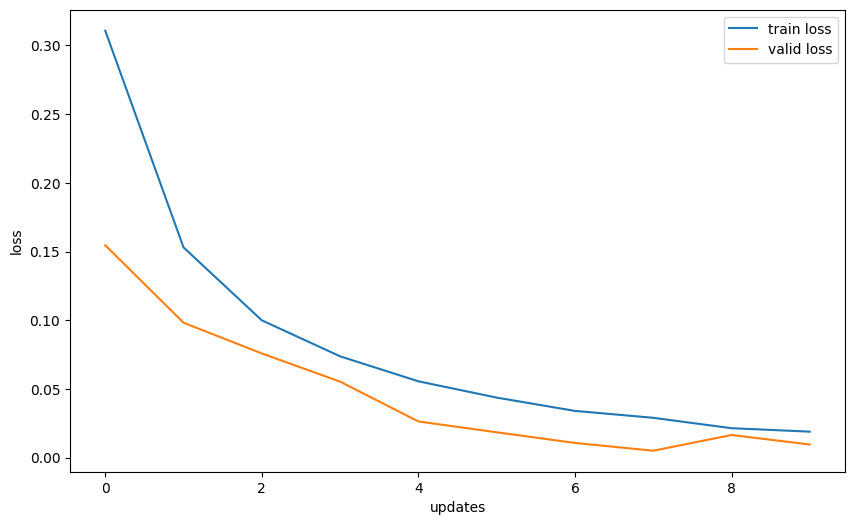

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

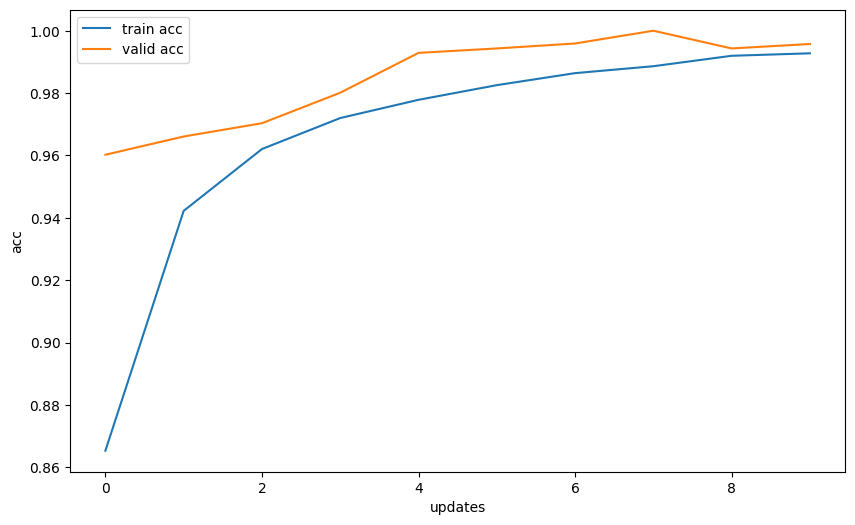

In [63]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [64]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.001 | Test Acc: 81.94%


# 9) Testing on some random news-like sentences

In [100]:
test_str = "Weed isn't a drug, it's a plant.It's really good for you."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([   0,   13,   30,    6, 2718,    5,   16,   12,    6, 8363,    9,    0,
          12,  118,   50,   21,   26,    9])

In [101]:
text_list = [x.item() for x in text]
text_list

[0, 13, 30, 6, 2718, 5, 16, 12, 6, 8363, 9, 0, 12, 118, 50, 21, 26, 9]

In [102]:
text = text.reshape(1, -1)  #because batch_size is 1

In [103]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [104]:
text.shape

torch.Size([1, 18])

In [105]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [106]:
predict(text, text_length)

tensor([1])

Turns out it's correctly classifying the sentences. It's not perfect but, it's doing a good job. " WEED DO BE GOOD FOR YOU?"


## 9.1) Here comes the BIG ONEs: Negative Negative Sentence Test

#### Sentence 1

In [111]:
test_str = "You are not a bad person"
text = torch.tensor(text_pipeline(test_str)).to(device)

In [113]:
text_list = [x.item() for x in text]

In [114]:
text = text.reshape(1, -1)  #because batch_size is 1

In [115]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [116]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [117]:
predict(text, text_length)

tensor([1])

#### Sentence 2

In [130]:
test_str = "I wasn't that bad of a person"
text = torch.tensor(text_pipeline(test_str)).to(device)

In [131]:
text_list = [x.item() for x in text]
text_list

[0, 108, 30, 14, 75, 8, 6, 1112]

In [133]:
text = text.reshape(1, -1)  #because batch_size is 1

In [134]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [135]:
text.shape

torch.Size([1, 8])

In [136]:
predict(text, text_length)

tensor([1])

## 9.2)  Moving on with the complex: Negative Positive Sentence Test

#### Sentence 1

In [137]:
test_str = "The Ant-Man movie we watched together wasn't that great."
text = torch.tensor(text_pipeline(test_str)).to(device)

In [140]:
text_list = [x.item() for x in text]
text_list

[0, 0, 10, 0, 23, 116, 11651, 268, 108, 30, 14, 110, 9]

In [141]:
text = text.reshape(1, -1)  #because batch_size is 1

In [142]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [143]:
text.shape

torch.Size([1, 13])

In [144]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [145]:
predict(text, text_length)

tensor([0])

### Sentence 2 ( this one's gonna be interesting )

In [148]:
test_str = "Yesterday's trip to Bangkok wasn't most fun."
text = torch.tensor(text_pipeline(test_str)).to(device)

In [149]:
text_list = [x.item() for x in text]
text_list

[0, 12, 754, 11, 0, 108, 30, 49, 122, 9]

In [150]:
text = text.reshape(1, -1)  #because batch_size is 1

In [151]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [152]:
text.shape

torch.Size([1, 10])

In [153]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [154]:
predict(text, text_length)

tensor([0])

## yay! it's working as expected!

# 10) Conclusion and report of the project

ALL IN ALL, our model has near perfect accuracy on the validation and test set. With that being the case, NO WONDER our model is able to correctly classify the sentences we tested it on. Every DOUBLE NEGATIVE AND NEGATIVE POSITIVE SENTENCE TESTS were correctly classified. It's a good model to use for sentiment analysis task.Now, we can use it on our web application to do sentiment analysis on Reddit posts.